## 1. Install and Import Required Libraries

In [1]:
# Install required packages
%pip install -q transformers datasets torch torchvision pillow scikit-learn matplotlib accelerate evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, ClassLabel

from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/home/shuli/miniconda3/envs/image_class/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 4090


## 2. Load and Explore the Dataset

In [3]:
# Load the colorectal histology dataset
print("Loading dataset...")
dataset = load_dataset("dpdl-benchmark/colorectal_histology")
print("\nDataset structure:")
print(dataset)

Loading dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5000
    })
})

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5000
    })
})


In [4]:
# Explore the dataset
print(f"\nDataset splits: {list(dataset.keys())}")
print(f"Number of samples in train: {len(dataset['train'])}")
print(f"\nFeatures: {dataset['train'].features}")

# Display sample data
sample = dataset['train'][0]
print(f"\nSample data keys: {sample.keys()}")
print(f"Label: {sample['label']}")


Dataset splits: ['train']
Number of samples in train: 5000

Features: {'image': Image(mode=None, decode=True), 'label': Value('int64'), 'filename': Value('string')}

Sample data keys: dict_keys(['image', 'label', 'filename'])
Label: 4


In [5]:
# Get label names - for colorectal histology dataset
# The dataset has 8 tissue types
label_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']
num_labels = len(label_names)
print(f"Number of classes: {num_labels}")
print(f"Class names: {label_names}")

# Create label2id and id2label mappings
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for idx, label in enumerate(label_names)}
print(f"\nLabel mapping: {id2label}")

Number of classes: 8
Class names: ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']

Label mapping: {0: 'Tumor', 1: 'Stroma', 2: 'Complex', 3: 'Lympho', 4: 'Debris', 5: 'Mucosa', 6: 'Adipose', 7: 'Empty'}


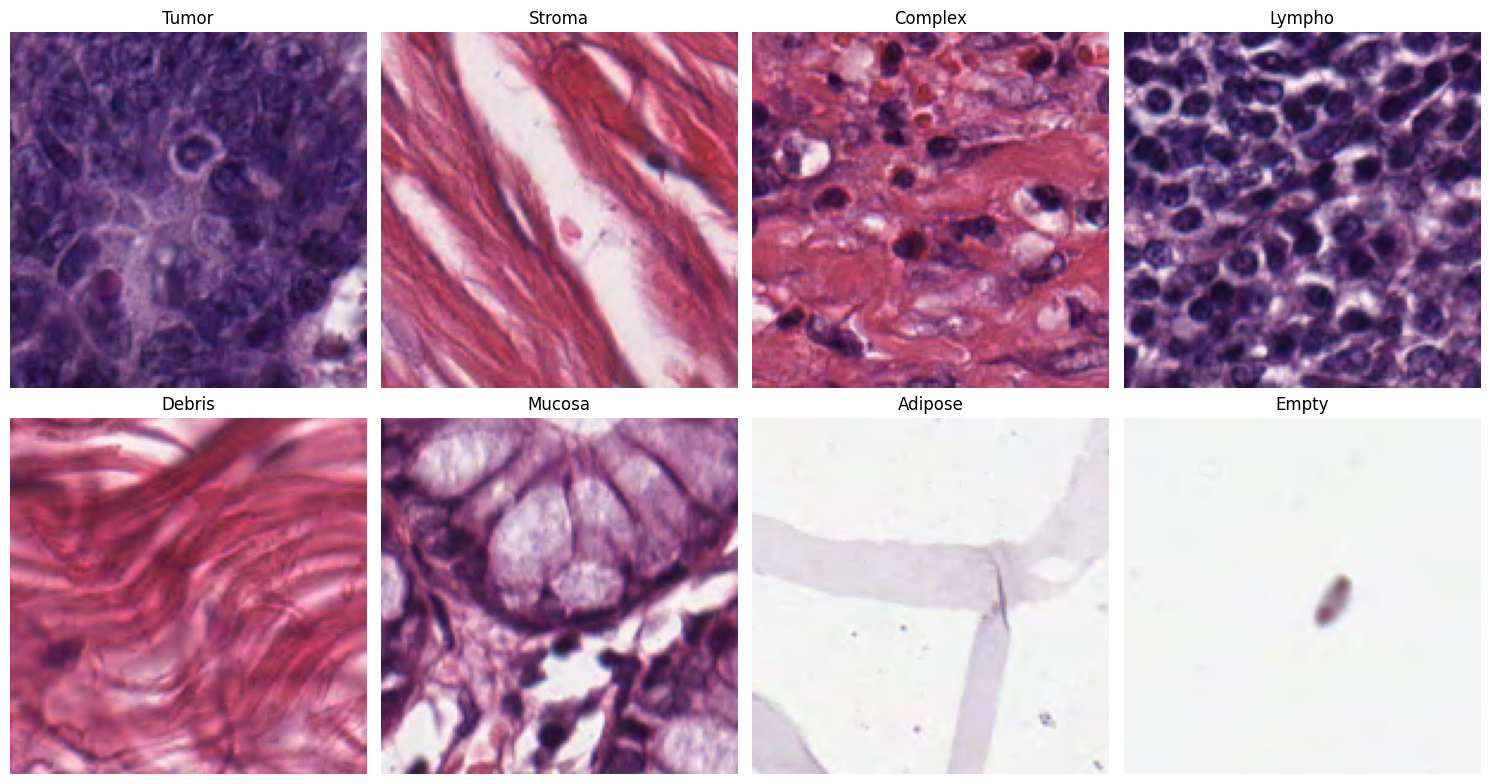

In [6]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for idx, label_name in enumerate(label_names):
    # Find first image with this label
    for sample in dataset['train']:
        if sample['label'] == idx:
            axes[idx].imshow(sample['image'])
            axes[idx].set_title(f"{label_name}")
            axes[idx].axis('off')
            break

plt.tight_layout()
plt.show()

## 3. Split Data into Train, Validation, and Test Sets

To obtain unbiased performance metrics, we use a 3-way split:
- **Training (68%)**: 3400 samples - for model training
- **Validation (16%)**: 800 samples - for model selection and early stopping
- **Test (16%)**: 800 samples - for final unbiased evaluation (never used during training)

This ensures 100 samples per class in both validation and test sets.

In [7]:
# Split the dataset into train (68%), validation (16%), and test (16%)

# Note: stratify_by_column requires ClassLabel type
dataset_with_class_label = dataset['train'].cast_column('label', ClassLabel(names=label_names))

# First split: separate test set (16% of total)
train_val_split = dataset_with_class_label.train_test_split(
    test_size=0.16, 
    seed=42, 
    stratify_by_column='label'
)
test_dataset = train_val_split['test']

# Second split: separate train and validation from remaining 84%
# 68% / 84% = 0.8095 for train, 16% / 84% = 0.1905 for validation
train_val_remaining = train_val_split['train']
train_val_split_final = train_val_remaining.train_test_split(
    test_size=0.1905,  # This gives us 16% of original data for validation
    seed=42,
    stratify_by_column='label'
)
train_dataset = train_val_split_final['train']
val_dataset = train_val_split_final['test']

print("Dataset Split:")
print("=" * 50)
print(f"Training samples:   {len(train_dataset)} (68%)")
print(f"Validation samples: {len(val_dataset)} (16%)")
print(f"Test samples:       {len(test_dataset)} (16%)")
print(f"Total:              {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print("=" * 50)
print(f"\n✓ Each class has ~100 samples in validation and test sets")

Dataset Split:
Training samples:   3399 (68%)
Validation samples: 801 (16%)
Test samples:       800 (16%)
Total:              5000

✓ Each class has ~100 samples in validation and test sets


## 4. Load Pre-trained Model and Processor

In [8]:
# Load the image processor (for preprocessing images)
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

print(f"Image processor loaded from {model_name}")
print(f"Expected image size: {processor.size}")

Image processor loaded from google/vit-base-patch16-224
Expected image size: {'height': 224, 'width': 224}


In [9]:
# Load the pre-trained ViT model for image classification
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Important: allows changing the classification head
)

print(f"\nModel loaded with {num_labels} output classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded with 8 output classes
Total parameters: 85,804,808
Trainable parameters: 85,804,808


## 5. Prepare Data Preprocessing

In [10]:
# Define preprocessing function
def preprocess_images(examples):
    """
    Preprocess images for the ViT model.
    """
    images = examples['image']
    # Convert images to RGB if they're not already
    images = [img.convert('RGB') if img.mode != 'RGB' else img for img in images]
    
    # Process images using the ViT processor
    inputs = processor(images, return_tensors='pt')
    
    # Add labels
    inputs['labels'] = examples['label']
    
    return inputs

In [11]:
# Apply preprocessing to the datasets
print("Preprocessing training data...")
train_dataset_processed = train_dataset.with_transform(preprocess_images)

print("Preprocessing validation data...")
val_dataset_processed = val_dataset.with_transform(preprocess_images)

print("\nData preprocessing complete!")

Preprocessing training data...
Preprocessing validation data...

Data preprocessing complete!


## 6. Define Evaluation Metrics

In [12]:
# Define metrics computation function
def compute_metrics(eval_pred):
    """
    Compute accuracy, precision, recall, and F1 score.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 7. Configure Training Arguments

In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-colorectal-histology",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    seed=42,
)

print("Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Number of epochs: {training_args.num_train_epochs}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup ratio: {training_args.warmup_ratio}")
print(f"  Weight decay: {training_args.weight_decay}")

Training configuration:
  Batch size: 16
  Number of epochs: 10
  Learning rate: 0.0002
  Warmup ratio: 0.1
  Weight decay: 0.01


## 8. Initialize Trainer and Start Fine-tuning

In [14]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_processed,
    eval_dataset=val_dataset_processed,
    compute_metrics=compute_metrics,
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [15]:
# Start training
print("Starting fine-tuning...\n")
train_result = trainer.train()

print("\nTraining completed!")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")

Starting fine-tuning...




Training completed!
Training loss: 0.1227
Training runtime: 202.55 seconds


## 9. Evaluate Model Performance on Validation Set

The validation set is used during training for model selection (early stopping). These metrics help us understand performance during training but are not the final unbiased evaluation.

In [16]:
# Evaluate on validation set (used for model selection)
print("Evaluating model on validation set...\n")
eval_result = trainer.evaluate()

print("\nValidation Results (used for model selection):")
print(f"  Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"  Precision: {eval_result['eval_precision']:.4f}")
print(f"  Recall: {eval_result['eval_recall']:.4f}")
print(f"  F1 Score: {eval_result['eval_f1']:.4f}")
print(f"  Loss: {eval_result['eval_loss']:.4f}")
print("\nNote: These metrics were used for model selection during training.")
print("      Test set metrics (next section) provide unbiased evaluation.")

Evaluating model on validation set...




Validation Results (used for model selection):
  Accuracy: 0.9738
  Precision: 0.9746
  Recall: 0.9738
  F1 Score: 0.9739
  Loss: 0.1290

Note: These metrics were used for model selection during training.
      Test set metrics (next section) provide unbiased evaluation.


## 10. Unbiased Evaluation on Test Set

Now we evaluate on the **test set**, which was never seen during training or model selection. This provides an unbiased estimate of the model's true performance.

In [17]:
# Preprocess test dataset
print("Preprocessing test data...")
test_dataset_processed = test_dataset.with_transform(preprocess_images)
print(f"✓ Test dataset prepared: {len(test_dataset_processed)} samples\n")

Preprocessing test data...
✓ Test dataset prepared: 800 samples



In [20]:
# Get predictions on TEST set (unbiased evaluation)
print("=" * 70)
print("UNBIASED EVALUATION ON TEST SET")
print("=" * 70)
print("\nGenerating predictions on test set (never seen during training)...\n")

test_predictions = trainer.predict(test_dataset_processed)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
test_true_labels = test_predictions.label_ids

# Calculate test metrics
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average='weighted'
)

print("=" * 70)
print("FINAL TEST SET RESULTS (Unbiased Performance)")
print("=" * 70)
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print("=" * 70)
print(f"\n✓ These are UNBIASED metrics - test set was never used during training!")
print(f"✓ Use these metrics for reporting model performance.")

UNBIASED EVALUATION ON TEST SET

Generating predictions on test set (never seen during training)...



FINAL TEST SET RESULTS (Unbiased Performance)
  Accuracy:  0.9587 (95.88%)
  Precision: 0.9618
  Recall:    0.9587
  F1 Score:  0.9594

✓ These are UNBIASED metrics - test set was never used during training!
✓ Use these metrics for reporting model performance.


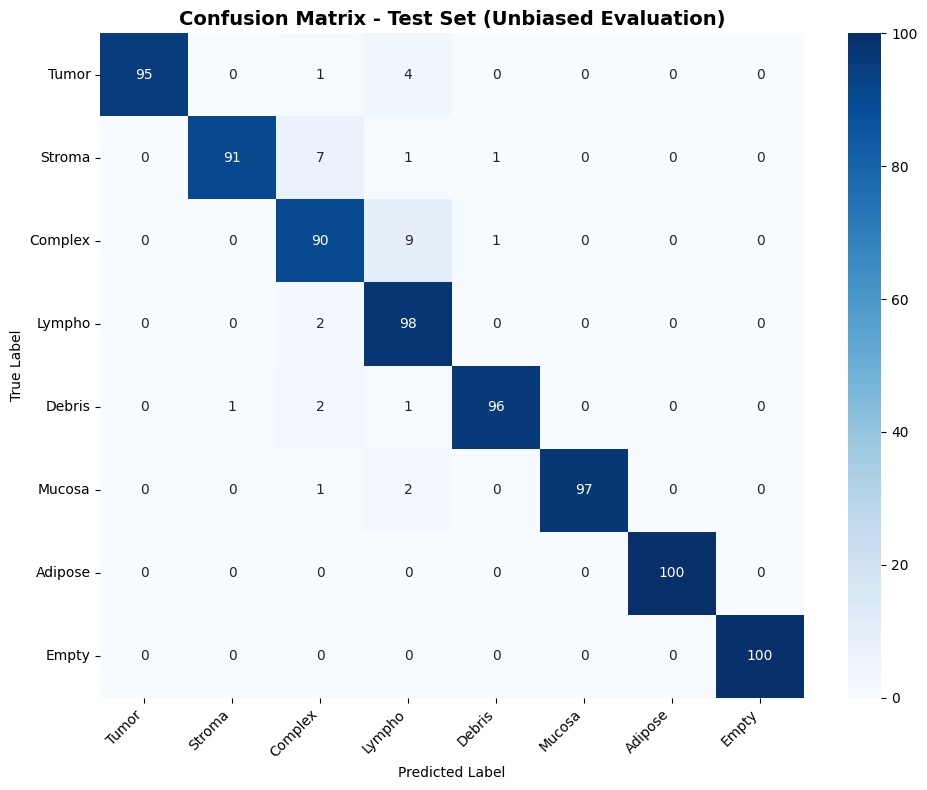

In [21]:
# Create and visualize confusion matrix for TEST set
cm_test = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('Confusion Matrix - Test Set (Unbiased Evaluation)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Calculate per-class metrics for TEST set
precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average=None
)

print("\nPer-Class Performance on Test Set:")
print("="*70)
print(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support'}")
print("="*70)
for idx, label_name in enumerate(label_names):
    print(f"{label_name:<25} {precision_test[idx]:<12.4f} {recall_test[idx]:<12.4f} {f1_test[idx]:<12.4f} {support_test[idx]}")
print("="*70)


Per-Class Performance on Test Set:
Class                     Precision    Recall       F1-Score     Support
Tumor                     1.0000       0.9500       0.9744       100
Stroma                    0.9891       0.9100       0.9479       100
Complex                   0.8738       0.9000       0.8867       100
Lympho                    0.8522       0.9800       0.9116       100
Debris                    0.9796       0.9600       0.9697       100
Mucosa                    1.0000       0.9700       0.9848       100
Adipose                   1.0000       1.0000       1.0000       100
Empty                     1.0000       1.0000       1.0000       100


## 11. Visualize Sample Predictions from Test Set

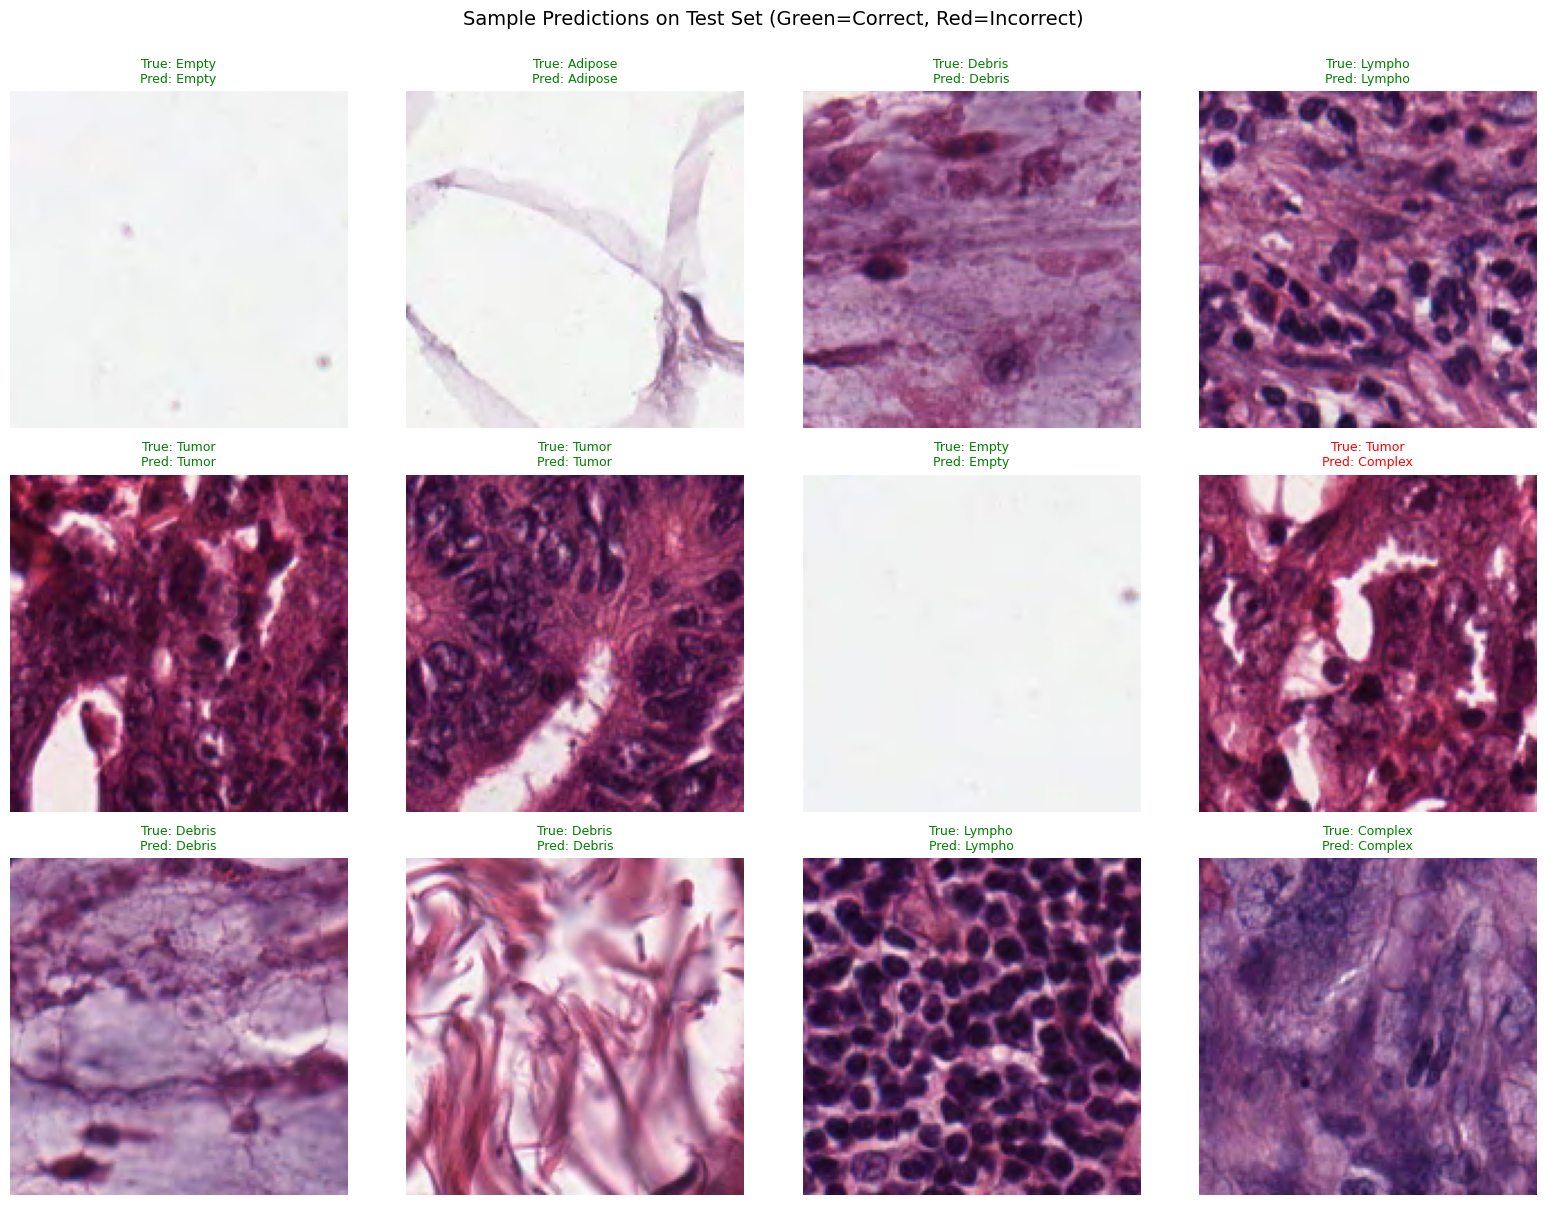

In [23]:
# Visualize some predictions from TEST set
num_samples = 12
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Get random samples from test set
np.random.seed(42)
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    sample = test_dataset[int(sample_idx)]
    true_label = sample['label']
    pred_label = test_pred_labels[sample_idx]
    
    # Display image
    axes[idx].imshow(sample['image'])
    
    # Set title with true and predicted labels
    color = 'green' if true_label == pred_label else 'red'
    axes[idx].set_title(
        f"True: {id2label[true_label]}\nPred: {id2label[pred_label]}",
        color=color,
        fontsize=9
    )
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 12. Save the Validated Model (Trained on 68% Data)

In [24]:
# Save the model and processor (trained on 68% of data)
model_save_path = "./vit-colorectal-histology-validated"
trainer.save_model(model_save_path)
processor.save_pretrained(model_save_path)

print(f"\nModel and processor saved to: {model_save_path}")
print("\nThis model was trained on 68% of the data with:")
print("  - 16% used for validation (model selection during training)")
print("  - 16% held out for test (unbiased evaluation)")
print("\n✓ Test set metrics provide unbiased performance estimates.")
print("✓ Use test set metrics for reporting model performance.")
print("\nYou can load the model later using:")
print(f"  model = ViTForImageClassification.from_pretrained('{model_save_path}')")
print(f"  processor = ViTImageProcessor.from_pretrained('{model_save_path}')")


Model and processor saved to: ./vit-colorectal-histology-validated

This model was trained on 68% of the data with:
  - 16% used for validation (model selection during training)
  - 16% held out for test (unbiased evaluation)

✓ Test set metrics provide unbiased performance estimates.
✓ Use test set metrics for reporting model performance.

You can load the model later using:
  model = ViTForImageClassification.from_pretrained('./vit-colorectal-histology-validated')
  processor = ViTImageProcessor.from_pretrained('./vit-colorectal-histology-validated')


## 13. Example: Make Predictions on New Images


Example Prediction:
  True Label: Complex
  Predicted Label: Complex
  Confidence: 0.9997


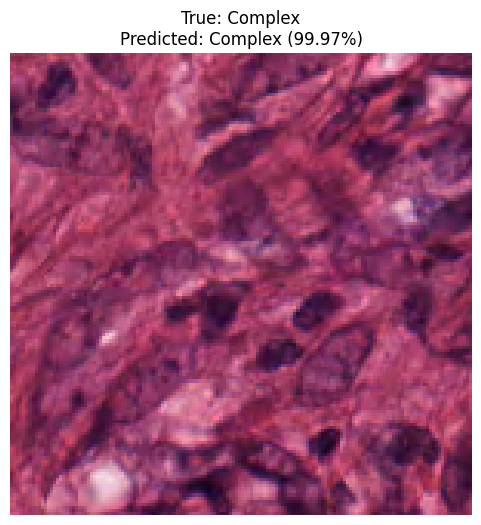

In [26]:
# Example function for making predictions on new images
def predict_image(image, model, processor):
    """
    Make a prediction on a single image.
    
    Args:
        image: PIL Image
        model: Fine-tuned ViT model
        processor: ViT image processor
    
    Returns:
        predicted_class: Predicted class name
        confidence: Confidence score
    """
    # Ensure image is in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        
    # Get predicted class and confidence
    predicted_class_idx = probabilities.argmax(-1).item()
    confidence = probabilities[0, predicted_class_idx].item()
    predicted_class = id2label[predicted_class_idx]
    
    return predicted_class, confidence

# Test the function on a sample from test set
model.to(device)
test_sample = test_dataset[np.random.randint(0, len(test_dataset))]
predicted_class, confidence = predict_image(test_sample['image'], model, processor)

print(f"\nExample Prediction:")
print(f"  True Label: {id2label[test_sample['label']]}")
print(f"  Predicted Label: {predicted_class}")
print(f"  Confidence: {confidence:.4f}")

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(test_sample['image'])
plt.title(f"True: {id2label[test_sample['label']]}\nPredicted: {predicted_class} ({confidence:.2%})")
plt.axis('off')
plt.show()

## 14. Retrain on Full Dataset for Production Deployment

Now that we've obtained unbiased metrics from the test set, we'll retrain on **100% of available data (5000 samples)** to maximize performance for production deployment.

**Why retrain with all data?**
- Test set metrics give us confidence in the model's true performance
- Using all 5000 samples will maximize the final model's accuracy
- Standard practice for production models after evaluation
- Validated model's test metrics serve as unbiased performance reference

In [27]:
# Prepare full dataset for production training
print("Preparing full dataset for production model...")

# Use the original full dataset (all 5000 samples)
full_dataset = dataset['train'].cast_column('label', ClassLabel(names=label_names))

print(f"Training samples:   {len(train_dataset)} (68%)")
print(f"Validation samples: {len(val_dataset)} (16%)")
print(f"Test samples:       {len(test_dataset)} (16%)")
print(f"Full dataset:       {len(full_dataset)} (100%)")

# Apply preprocessing
full_dataset_processed = full_dataset.with_transform(preprocess_images)

print(f"\n✓ Full dataset prepared: {len(full_dataset_processed)} samples for deployment model")
print("✓ Test set metrics from validated model will be used for performance reporting")

Preparing full dataset for production model...
Training samples:   3399 (68%)
Validation samples: 801 (16%)
Test samples:       800 (16%)
Full dataset:       5000 (100%)

✓ Full dataset prepared: 5000 samples for deployment model
✓ Test set metrics from validated model will be used for performance reporting


In [28]:
# Load a fresh model for training on full dataset
print("Loading fresh pre-trained model for full dataset training...")

model_deployment = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print(f"✓ Model loaded with {num_labels} output classes")

Loading fresh pre-trained model for full dataset training...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded with 8 output classes


In [ ]:
# Configure training arguments for full dataset training
# Using same hyperparameters that worked well in validation
# Reduced to 5 epochs based on validated model's best performance at epoch 5
training_args_deployment = TrainingArguments(
    output_dir="./vit-colorectal-histology-deploy",
    per_device_train_batch_size=16,
    num_train_epochs=5,  # Optimized based on validation results showing best performance at epoch 5
    learning_rate=2e-4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs-deployment',
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    seed=42,
)

print("Training configuration for deployment model:")
print(f"  Dataset: Full dataset ({len(full_dataset_processed)} samples, 100%)")
print(f"  Batch size: {training_args_deployment.per_device_train_batch_size}")
print(f"  Epochs: {training_args_deployment.num_train_epochs} (optimized based on validation results)")
print(f"  Learning rate: {training_args_deployment.learning_rate}")

In [ ]:
# Create Trainer for deployment model (no validation set)
trainer_deployment = Trainer(
    model=model_deployment,
    args=training_args_deployment,
    train_dataset=full_dataset_processed,
    # Note: No eval_dataset - we're using all data for training
)

print("✓ Deployment trainer initialized successfully!")

In [ ]:
# Train the deployment model on full dataset
print("=" * 70)
print("TRAINING DEPLOYMENT MODEL ON FULL DATASET (100%)")
print("=" * 70)
print(f"\nTraining on all {len(full_dataset_processed)} samples...")
print("Validated model's test set metrics will be used for performance reporting.\n")

train_result_deployment = trainer_deployment.train()

print("\n" + "=" * 70)
print("DEPLOYMENT MODEL TRAINING COMPLETED!")
print("=" * 70)
print(f"\nTraining loss: {train_result_deployment.training_loss:.4f}")
print(f"Training runtime: {train_result_deployment.metrics['train_runtime']:.2f} seconds")
print(f"\n✓ Model trained on 100% of available data (all 5000 samples)")
print(f"✓ Use validated model's test set metrics for performance reporting")

In [ ]:
# Save the deployment model
deployment_save_path = "./vit-colorectal-histology-deploy"
trainer_deployment.save_model(deployment_save_path)
processor.save_pretrained(deployment_save_path)

print("=" * 70)
print("DEPLOYMENT MODEL SAVED")
print("=" * 70)
print(f"\nModel saved to: {deployment_save_path}")
print("\n📊 Model Comparison:")
print(f"  • Validated Model: ./vit-colorectal-histology-validated")
print(f"    - Trained on: 68% of data (3400 samples)")
print(f"    - Val set: 16% for model selection")
print(f"    - Test set: 16% for unbiased metrics")
print(f"\n  • Deployment Model: {deployment_save_path}")
print(f"    - Trained on: 100% of data (5000 samples)")
print(f"    - Purpose: Production deployment (maximum performance)")
print("\n✓ This deployment model should be used for:")
print("  - Hugging Face Hub upload")
print("  - Production inference")
print("  - Gradio app deployment")
print("\n✓ Report performance using validated model's TEST set metrics")

## Summary

This notebook demonstrated:
1. Loading the pre-trained ViT model from Hugging Face
2. Loading the colorectal histology dataset (5000 samples)
3. **Splitting data into train (68%), validation (16%), and test (16%) sets**
4. Fine-tuning the model on training data
5. Using validation set for model selection (early stopping)
6. **Evaluating on test set for unbiased performance metrics**
7. Visualizing results with confusion matrices and sample predictions
8. Saving the validated model with unbiased test metrics
9. **Retraining on 100% of data (5000 samples) for production deployment**

### Two Models Created:

**1. Validated Model** (`vit-colorectal-histology-validated/`)
- Trained on 68% of data (3400 samples)
- Validation set (16%): Used for model selection
- Test set (16%): Provides unbiased metrics
- **Use test set metrics for scientific reporting**

**2. Deployment Model** (`vit-colorectal-histology-deploy/`)
- Trained on 100% of data (5000 samples)
- Maximum performance due to using all available training data
- **Use this for production and Hugging Face Hub**
- Report performance using validated model's test metrics

The deployment model can now classify colorectal histology images into different tissue types with maximum accuracy!